# Introduction

## Libraries and Packages

In [1]:
# pip install torch torchvision torchaudio 
# !pip install -q torch_geometric  # Install PyG
# !pip install -q pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv
# !pip install -q pyg-library

!pip install torch-geometric \
  torch-sparse \
  torch-scatter \
  torch-cluster \
  torch-cluster \
  pyg-lib \
  -f https://data.pyg.org/whl/torch-2.5.1+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 61.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 116.0 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 90.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.5 MB/s eta 0:00:0000:01


In [ ]:
import torch
torch.__version__

# !pip install pyg-lib -f https://data.pyg.org/whl/torch-2.5.1+cu121.html
# !pip install git+https://github.com/pyg-team/pyg-lib.git

In [3]:
import os
import json
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.data import HeteroData
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import Linear
from torch_geometric.nn import GCNConv

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## Configs

In [4]:
author_paperList = '/kaggle/input/hcsp-dataset/data/author.pth'
author_later = '/kaggle/input/hcsp-dataset/data/author_later.json'
paper_later = '/kaggle/input/hcsp-dataset/data/paper_later.json'


test_p = '/kaggle/input/hcsp-dataset/data/test_p.txt'
test_n = '/kaggle/input/hcsp-dataset/data/test_n.txt'
train_p = '/kaggle/input/hcsp-dataset/data/train_p.txt'
train_n = '/kaggle/input/hcsp-dataset/data/train_n.txt'

batch = 512
epoch = 10
learning_rate = 0.05
lstm_layers_num = 2
lstm_dropout = 0.4
gnn_dropout = 0.
classification_threshold = 0.5

paperList_len = 3

neighbor = 5
neighbor_step = 2
nodeType = 'author'

In [ ]:
# paperList_len = 1024  # Ensure this matches the actual expected length
# author_paperList = 'data/author_papers.pth'
# author_later = 'data/authors.json'
# paper_later = 'data/papers.json'
# lstm_dropout = 0.2
# lstm_layers_num = 2
# gnn_dropout = 0.3
# neighbor = 10
# neighbor_step = 2
# nodeType = 'author'
# classification_threshold = 0.5

## Dataset Preprocessing

In [54]:
# Load JSON metadata
with open(author_later, 'r') as f:
    author_data = json.load(f)
with open(paper_later, 'r') as f:
    paper_data = json.load(f)

print(f"Loaded {len(author_data)} authors and {len(paper_data)} papers.")

# Function to load text files
def load_text_file(file_path, num_examples=5):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    print(f"Loaded {len(lines)} entries from {file_path}. Showing {num_examples} examples:")
    for line in lines[:num_examples]:
        print(line.strip())

# Show a few examples from test/train positive/negative sets
print("\nTest Positive Examples:")
load_text_file(test_p)

print("\nTest Negative Examples:")
load_text_file(test_n)

print("\nTrain Positive Examples:")
load_text_file(train_p)

print("\nTrain Negative Examples:")
load_text_file(train_n)


Loaded 16249 authors and 6952 papers.

Test Positive Examples:
Loaded 256 entries from /kaggle/input/hcsp-dataset/data/test_p.txt. Showing 5 examples:
2233 5402
9188 9189
14436 2564
4520 11291
8691 5148

Test Negative Examples:
Loaded 256 entries from /kaggle/input/hcsp-dataset/data/test_n.txt. Showing 5 examples:
43 670
4856 239
386 573
15753 70
1978 12695

Train Positive Examples:
Loaded 3141 entries from /kaggle/input/hcsp-dataset/data/train_p.txt. Showing 5 examples:
14514 14510
2228 2229
10796 10798
467 1742
3597 1863

Train Negative Examples:
Loaded 4204 entries from /kaggle/input/hcsp-dataset/data/train_n.txt. Showing 5 examples:
14510 903
2228 12572
5417 10796
4720 467
845 3597


In [57]:
author_data[0][0]

{'SO': 'JOURNAL OF GLOBAL INFORMATION MANAGEMENT',
 'TI': 'Who Contributes to the Sunk Costs of Motor Vehicle Carbon Emissions and Human Capital?',
 'DE': 'Driving Violations Scale; Measurement Model; Motor Vehicle; Sociodemographic Characteristics; Transportation Carbon Emissions Reduction',
 'AB': 'Most carbon emission reduction studies in transportation focus on the natural use of motor vehicles. However, little attention has been paid to fatal driving violations that lead to the sunk costs of human resources investment and motor vehicle carbon emissions in the manufacturing process of motor vehicles. This article aimed to determine if a driver would be seriously harmful to human capital investment and carbon emissions reduction. 1893 drivers in China were formally surveyed by questionnaire to find out the statistical characteristics. Results indicated that different drivers show significant differences in different driving violations dimensions. Specific drivers showing horrible dr

In [61]:
paper_data[0]

{'SO': 0,
 'TI': 'Who Contributes to the Sunk Costs of Motor Vehicle Carbon Emissions and Human Capital?',
 'DE': 'Driving Violations Scale; Measurement Model; Motor Vehicle; Sociodemographic Characteristics; Transportation Carbon Emissions Reduction',
 'AB': 'Most carbon emission reduction studies in transportation focus on the natural use of motor vehicles. However, little attention has been paid to fatal driving violations that lead to the sunk costs of human resources investment and motor vehicle carbon emissions in the manufacturing process of motor vehicles. This article aimed to determine if a driver would be seriously harmful to human capital investment and carbon emissions reduction. 1893 drivers in China were formally surveyed by questionnaire to find out the statistical characteristics. Results indicated that different drivers show significant differences in different driving violations dimensions. Specific drivers showing horrible driving violation (HDV) and dangerous drivi

In [52]:
all_data = torch.load(author_paperList)

<ipython-input-52-4f2b3e019fc7>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_data = torch.load(author_paperList)


In [53]:
print(f"Loaded {len(all_data)} author-paper relationships.")

Loaded 16249 author-paper relationships.


In [6]:
all_data[:5]

[tensor([[-1.2002,  0.3761, -0.5483,  ...,  0.3048, -0.5878,  0.8080]],
        requires_grad=True),
 tensor([[-1.2002,  0.3761, -0.5483,  ...,  0.3048, -0.5878,  0.8080]],
        requires_grad=True),
 tensor([[-1.2002,  0.3761, -0.5483,  ...,  0.3048, -0.5878,  0.8080]],
        requires_grad=True),
 tensor([[ 1.1751, -0.9252, -1.3913,  ...,  0.3677, -1.4454,  1.0538],
         [ 0.9970, -0.2351, -1.2078,  ...,  0.2373, -0.5921,  1.3891],
         [-0.7351, -1.1610, -1.6025,  ...,  0.4113, -1.0132,  0.8641]],
        requires_grad=True),
 tensor([[-0.7351, -1.1610, -1.6025,  ...,  0.4113, -1.0132,  0.8641]],
        requires_grad=True)]

In [7]:
# Ensure all embeddings are of uniform size
for i in range(len(all_data)):
    data = all_data[i]
    if data.shape[0] < paperList_len:
        temp = torch.zeros(paperList_len - data.shape[0], 1024)
        all_data[i] = torch.cat([temp, data], dim = 0)
    if data.shape[0] > paperList_len:
        temp = torch.split(data, [data.shape[0] - paperList_len, paperList_len], 
                           dim=0)[-1]
        all_data[i] = temp

In [8]:
# uniform dataset
all_data[:5]

[tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-1.2002,  0.3761, -0.5483,  ...,  0.3048, -0.5878,  0.8080]],
        grad_fn=<CatBackward0>),
 tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-1.2002,  0.3761, -0.5483,  ...,  0.3048, -0.5878,  0.8080]],
        grad_fn=<CatBackward0>),
 tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-1.2002,  0.3761, -0.5483,  ...,  0.3048, -0.5878,  0.8080]],
        grad_fn=<CatBackward0>),
 tensor([[ 1.1751, -0.9252, -1.3913,  ...,  0.3677, -1.4454,  1.0538],
         [ 0.9970, -0.2351, -1.2078,  ...,  0.2373, -0.5921,  1.3891],
         [-0.7351, -1.1610, -1.6025,  ...,  0.4113, -1.0132,  0.8641]],
        requires_grad=True),
 tensor([[ 0.000

In [11]:
# Create heterogeneous graph data object
data = HeteroData()
data['author'].x = torch.tensor([i for i in range(16249)])
data['paper'].x = torch.tensor([i for i in range(6952)])
data['author'].num_nodes = 16249
data['paper'].num_nodes = 6952

In [12]:
data

HeteroData(
  author={
    x=[16249],
    num_nodes=16249,
  },
  paper={
    x=[6952],
    num_nodes=6952,
  }
)

### Actual Dataset Loading

In [13]:
# Load author-paper relationships
author2paper = [[], []]
with open(author_later, 'r', encoding='utf-8') as f:
    author_data = json.load(f)
    for i, papers in enumerate(author_data):
        for paper in papers:
            author2paper[0].append(i)
            author2paper[1].append(paper['DI'])

data['author', 'writes', 'paper'].edge_index = torch.tensor(author2paper, dtype=torch.long)

In [14]:
data

HeteroData(
  author={
    x=[16249],
    num_nodes=16249,
  },
  paper={
    x=[6952],
    num_nodes=6952,
  },
  (author, writes, paper)={ edge_index=[2, 25034] }
)

In [15]:
# Load paper-paper citation relationships
paper2paper = [[], []]
with open(paper_later, 'r', encoding='utf-8') as f:
    paper_data = json.load(f)
    for paper in paper_data:
        for cited_paper in paper.get('CR', []):
            paper2paper[0].append(cited_paper)
            paper2paper[1].append(paper['DI'])

data['paper', 'cite', 'paper'].edge_index = torch.tensor(paper2paper, dtype=torch.long)


In [16]:
data

HeteroData(
  author={
    x=[16249],
    num_nodes=16249,
  },
  paper={
    x=[6952],
    num_nodes=6952,
  },
  (author, writes, paper)={ edge_index=[2, 25034] },
  (paper, cite, paper)={ edge_index=[2, 14853] }
)

In [17]:
# Load paper-journal relationships
paper2journal = [[], []]
for paper in paper_data:
    paper2journal[0].append(paper['DI'])
    paper2journal[1].append(paper['SO'])

data['paper', 'in', 'journal'].edge_index = torch.tensor(paper2journal, dtype=torch.long)

In [18]:
data

HeteroData(
  author={
    x=[16249],
    num_nodes=16249,
  },
  paper={
    x=[6952],
    num_nodes=6952,
  },
  (author, writes, paper)={ edge_index=[2, 25034] },
  (paper, cite, paper)={ edge_index=[2, 14853] },
  (paper, in, journal)={ edge_index=[2, 6952] }
)

In [19]:
# Convert to undirected graph and add meta-paths
data_undirected=T.ToUndirected()(data)

metapaths = [[('author', 'paper'), ('paper', 'author')], 
             [('author', 'paper'), ('paper', 'paper'),('paper', 'author')],
             [('author', 'paper'), ('paper', 'journal'),('journal', 'paper'),('paper', 'author')],
            ]

In [20]:
data_metapath=T.AddMetaPaths(metapaths=metapaths, 
                             drop_orig_edges=True, 
                             drop_unconnected_nodes=True, 
                             max_sample=20)(data_undirected)

/usr/local/lib/python3.10/dist-packages/torch_geometric/transforms/add_metapaths.py:111: UserWarning: 'drop_orig_edges' is deprecated. Use 'drop_orig_edge_types' instead
  warnings.warn("'drop_orig_edges' is deprecated. Use "
/usr/local/lib/python3.10/dist-packages/torch_geometric/transforms/add_metapaths.py:116: UserWarning: 'drop_unconnected_nodes' is deprecated. Use 'drop_unconnected_node_types' instead
  warnings.warn("'drop_unconnected_nodes' is deprecated. Use "
/usr/local/lib/python3.10/dist-packages/torch_geometric/edge_index.py:863: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return torch.sparse_csr_tensor(
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set 's

In [21]:
# Saving the metapaths graphs
torch.save(data_metapath, 'lxx.pth')
data_gnn = torch.load('lxx.pth').cuda()
# data_gnn = torch.load('lxx.pth')

<ipython-input-21-2e89de41c583>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_gnn = torch.load('lxx.pth').cuda()


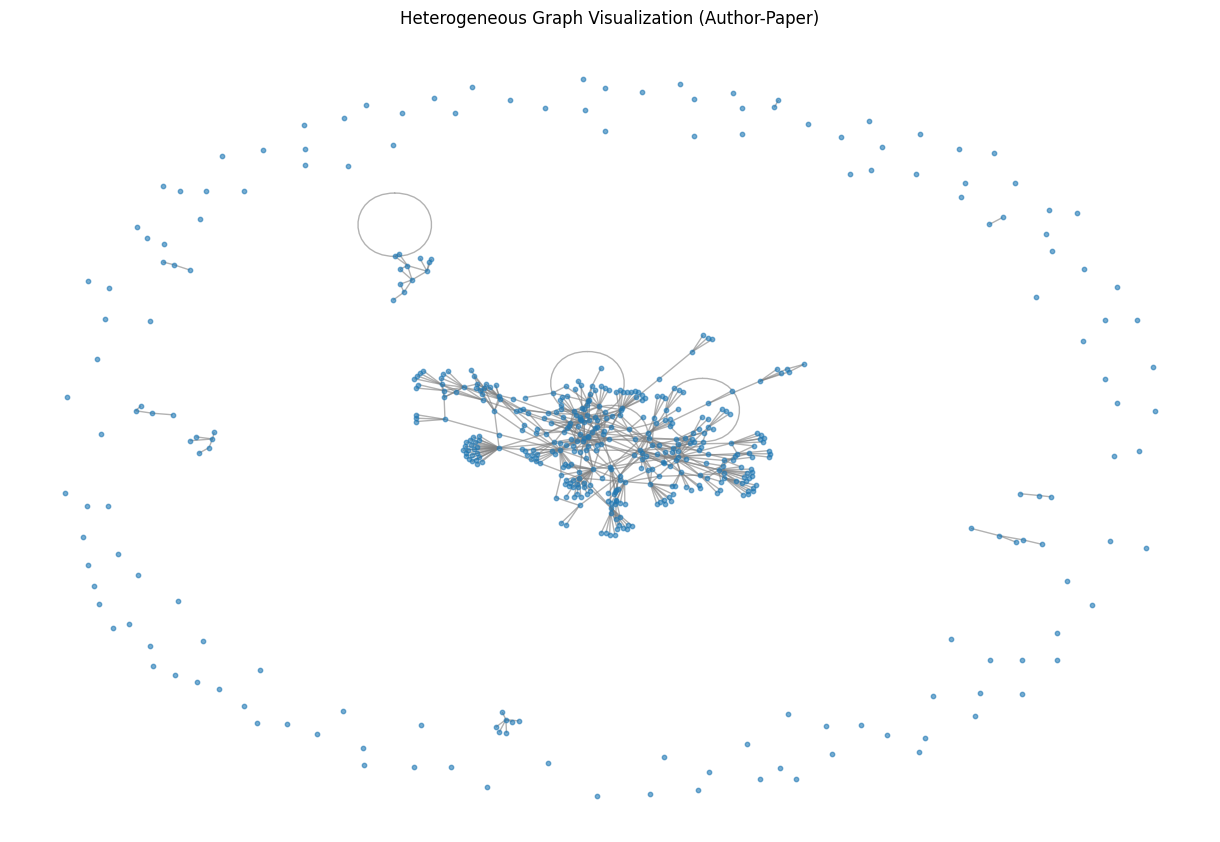

In [26]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_hetero_graph(data_gnn, num_nodes=300):
    # Create a new NetworkX graph
    G = nx.Graph()

    # Extract a subset of nodes
    author_nodes = min(num_nodes, data_gnn['author'].num_nodes)
    paper_nodes = min(num_nodes, data_gnn['paper'].num_nodes)

    # Add nodes to the graph
    G.add_nodes_from(range(author_nodes), node_type="author")
    G.add_nodes_from(range(paper_nodes), node_type="paper")

    # Add 'author-writes-paper' edges
    edge_index = data_gnn[('author', 'writes', 'paper')].edge_index
    for src, dst in edge_index.t().tolist()[:num_nodes]:  # Take only a subset for visualization
        G.add_edge(src, dst, relation="writes")

    # Add 'paper-cites-paper' edges
    edge_index = data_gnn[('paper', 'cite', 'paper')].edge_index
    for src, dst in edge_index.t().tolist()[:num_nodes]:
        G.add_edge(src, dst, relation="cites")

    # Draw the graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)  # Layout for better spacing
    nx.draw(G, pos, with_labels=False, node_size=10, alpha=0.6, edge_color="gray")

    plt.title("Heterogeneous Graph Visualization (Author-Paper)")
    plt.show()

# Call function
visualize_hetero_graph(data)


This visualization represents a **heterogeneous graph** of authors, papers, and journals, where nodes correspond to **authors and papers**, and edges represent relationships like **"writes" (author → paper)** and **"cites" (paper → paper)**. The layout positions nodes using a force-directed algorithm, making connected nodes appear closer together. Since the dataset is large, only a subset is displayed to avoid clutter.

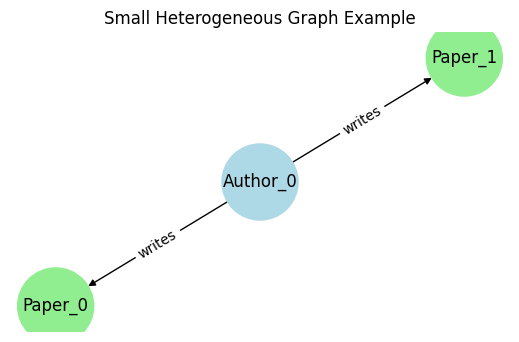

In [29]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Manually extract a small subgraph (1 author, 2 papers)
small_data = HeteroData()
small_data['author'].x = torch.tensor([0])  # One author
small_data['paper'].x = torch.tensor([0, 1])  # Two papers
small_data['author', 'writes', 'paper'].edge_index = torch.tensor([[0, 0], [0, 1]])

# Convert to NetworkX (manually handling hetero data)
G = nx.DiGraph()
G.add_node("Author_0", type="author")
G.add_node("Paper_0", type="paper")
G.add_node("Paper_1", type="paper")

G.add_edge("Author_0", "Paper_0", relation="writes")
G.add_edge("Author_0", "Paper_1", relation="writes")

# Draw the graph
plt.figure(figsize=(5, 3))
pos = nx.spring_layout(G)  # Node positioning
node_colors = {"author": "lightblue", "paper": "lightgreen"}
node_labels = {n: n for n in G.nodes()}

nx.draw(G, pos, with_labels=True, node_size=3000, node_color=[node_colors[G.nodes[n]["type"]] for n in G.nodes()])
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d["relation"] for u, v, d in G.edges(data=True)})

plt.title("Small Heterogeneous Graph Example")
plt.show()


In [33]:
# import torch
# import networkx as nx
# import matplotlib.pyplot as plt
# from torch_geometric.data import HeteroData

# # For this example, let's extract all nodes involved in the two relations
# writes_edges = data[("author", "writes", "paper")].edge_index
# cite_edges = data[("paper", "cite", "paper")].edge_index

# # Determine all unique nodes
# all_authors = set(writes_edges[0].tolist())
# all_papers = set(writes_edges[1].tolist())
# all_papers |= set(cite_edges[0].tolist())
# all_papers |= set(cite_edges[1].tolist())

# # Create a NetworkX graph
# G = nx.DiGraph()

# # Add all author nodes with attributes
# for a in all_authors:
#     G.add_node(f"Author_{a}", type="author")

# # Add all paper nodes with attributes
# for p in all_papers:
#     G.add_node(f"Paper_{p}", type="paper")

# # Add "writes" edges
# for i in range(writes_edges.shape[1]):
#     G.add_edge(f"Author_{writes_edges[0, i].item()}", f"Paper_{writes_edges[1, i].item()}", relation="writes")

# # Add "cite" edges
# for i in range(cite_edges.shape[1]):
#     G.add_edge(f"Paper_{cite_edges[0, i].item()}", f"Paper_{cite_edges[1, i].item()}", relation="cites")

# # Draw graph
# plt.figure(figsize=(6, 4))
# pos = nx.spring_layout(G)  # Layout for better visualization
# node_colors = {"author": "lightblue", "paper": "lightgreen"}

# # Use list comprehension safely now that all nodes have a 'type'
# nx.draw(G, pos, with_labels=True, node_size=3000, 
#         node_color=[node_colors[G.nodes[n]["type"]] for n in G.nodes()])

# # Draw edge labels
# edge_labels = {(u, v): d["relation"] for u, v, d in G.edges(data=True)}
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# plt.title("Small Subgraph of Author-Paper Relationships")
# plt.show()


In [27]:
# import seaborn as sns

# def plot_degree_distribution(data_gnn):
#     author_degrees = data_gnn['author'].num_nodes
#     paper_degrees = data_gnn['paper'].num_nodes

#     plt.figure(figsize=(10, 5))
#     sns.histplot([author_degrees, paper_degrees], bins=50, kde=True, log_scale=True)
#     plt.title("Node Degree Distribution (Authors & Papers)")
#     plt.xlabel("Degree")
#     plt.ylabel("Frequency")
#     plt.legend(["Authors", "Papers"])
#     plt.show()

# plot_degree_distribution(data)

In [22]:
data_gnn

HeteroData(
  metapath_dict={
    (author, metapath_0, author)=[2],
    (author, metapath_1, author)=[3],
    (author, metapath_2, author)=[4],
  },
  author={
    x=[16249],
    num_nodes=16249,
  },
  (author, metapath_0, author)={ edge_index=[2, 89279] },
  (author, metapath_1, author)={ edge_index=[2, 168362] },
  (author, metapath_2, author)={ edge_index=[2, 323364] }
)

In [23]:
data_gnn['author'].num_nodes

16249

## Models

In [24]:
class SemanticAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(SemanticAttentionLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.b = nn.Parameter(torch.zeros(size=(1, out_features)))
        nn.init.xavier_uniform_(self.b.data, gain=1.414)
        self.q = nn.Parameter(torch.zeros(size=(1, out_features)))
        nn.init.xavier_uniform_(self.q.data, gain=1.414)
        self.Tanh = nn.Tanh()


    def forward(self, input, P):
        h = torch.mm(input, self.W)
        h_prime = self.Tanh(h + self.b.repeat(h.size()[0], 1))
        semantic_attentions = torch.mm(h_prime, torch.t(self.q)).view(P, -1)
        N = semantic_attentions.size()[1]
        semantic_attentions = semantic_attentions.mean(dim=1, keepdim=True)
        semantic_attentions = F.softmax(semantic_attentions, dim=0)



        att_score_weight =torch.transpose(semantic_attentions,0,1)

        semantic_attentions = semantic_attentions.view(P, 1, 1)


        semantic_attentions = semantic_attentions.repeat(1, N, self.in_features)

        input_embedding = input.view(P, N, self.in_features)

        h_embedding = torch.mul(input_embedding, semantic_attentions)

        h_embedding = torch.sum(h_embedding, dim=0).squeeze()

        return h_embedding,att_score_weight


In [26]:
# Define LHGI Model (GCN + Attention)
class LHGI(nn.Module):
    def __init__(self, input_dim, att_dim, node_num, dropout_rate=0.):
        super(LHGI, self).__init__()

        self.dropout_rate = dropout_rate
        self.linear = Linear(-1, input_dim)

        self.semantic_level_attention = SemanticAttentionLayer(input_dim, att_dim)
        self.sig = torch.sigmoid

        self.conv_1 = GCNConv(input_dim, input_dim)
        self.conv_2 = GCNConv(input_dim, input_dim)
        self.embedding = torch.nn.Embedding(node_num+1, input_dim)

    def forward(self, graph, nodeType):
        x_dict = graph.x_dict
        edge_index_dict = graph.edge_index_dict


        X_origin = x_dict[nodeType]
        X_origin = self.embedding(X_origin)
        X_origin = F.relu(X_origin)

        GNN_conv_list_1 = []

        for edge in edge_index_dict.values():
            X = self.conv_1(X_origin, edge)
            X = F.relu(X)
            X = F.dropout(X, p=self.dropout_rate, training=self.training)

            X = self.conv_2(X, edge)
            X = F.relu(X)
            X = F.dropout(X, p=self.dropout_rate, training=self.training)

            GNN_conv_list_1.append(X)

        muilt_gcn_out = torch.cat(GNN_conv_list_1, dim=0)

        Att_out,att_score_weight = self.semantic_level_attention(muilt_gcn_out, len(edge_index_dict))
        Att_out = Att_out

        return Att_out,att_score_weight


In [27]:
class LstmModel(nn.Module):
    def __init__(self):
        super(LstmModel, self).__init__()
        self.dropout = lstm_dropout
        self.num_layers = lstm_layers_num
        self.lstm = nn.LSTM(input_size=1024, hidden_size=256, 
                            num_layers=self.num_layers, dropout=self.dropout, 
                            batch_first=True)
        self.linear = nn.Linear(256, 64)
        
        self.attention = nn.MultiheadAttention(embed_dim=64, 
                                            num_heads=4, batch_first=True)
        self.attLinear = nn.Linear(64, 32)
        
    def forward(self, x):
        out, (h, c) = self.lstm(x)
        out = self.linear(out)
        attn_output, attn_output_weights = self.attention(out, out, out)
        attn_output = torch.sum(attn_output, dim=1)
        attn_output = self.attLinear(attn_output)
        return attn_output


In [28]:
class endModel(nn.Module):
    def __init__(self):
        super(endModel, self).__init__()
        self.paperList = all_data
        self.linear_gnn = nn.Linear(64, 32)
        self.gnn_dropout = gnn_dropout
        self.gnnModel = LHGI(input_dim=64, att_dim=32, 
                             node_num=data_gnn['author'].num_nodes, 
                             dropout_rate=self.gnn_dropout)
        self.lstmModel = LstmModel()

        self.linear_GnnLstm = nn.Linear(32, 16)
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        self.query = torch.randn(32, 1).cuda()
        self.softmax = nn.Softmax(dim=1)

    def get_gnnPath(self, idx: int):
        loader = NeighborLoader(data_gnn,
                                num_neighbors={key: [neighbor] * neighbor_step for key in data_gnn.edge_types},
                                batch_size=1,
                                directed=True,
                                input_nodes=(nodeType, [idx]),)
        sampled_data = next(iter(loader))
        return sampled_data
    
    def cat_LstmGnn(self, lstmEmbed, gnnEmbed):
        t1 = lstmEmbed @ self.query
        t2 = gnnEmbed @ self.query
        t = self.softmax(torch.cat([t1, t2], dim=1))
        t1 = torch.split(t, 1, dim=1)[0]
        t2 = torch.split(t, 1, dim=1)[1]
        res = lstmEmbed * t1 + gnnEmbed * t2
        return res
        
        
    def forward(self, x):
        author_gnnEmbed = []
        m = True
        for item in torch.split(x, 1, dim=0):
            author1_gnn,att_score_weight = self.gnnModel(self.get_gnnPath(item[0][0].item()), nodeType)
            author1_gnn=author1_gnn[:1]
            author2_gnn,_ = self.gnnModel(self.get_gnnPath(item[0][1].item()), nodeType)
            author2_gnn = author2_gnn[:1]
            author_temp = torch.cat([author1_gnn, author2_gnn], dim=0)
            if m:
                author_gnnEmbed = author_temp.unsqueeze(dim=0)
                m = False
            else:
                author_gnnEmbed = torch.cat([author_gnnEmbed, author_temp.unsqueeze(dim=0)], dim=0)
        author1_gnnEmbed = torch.split(author_gnnEmbed, 1, dim=1)[0].squeeze()
        author2_gnnEmbed = torch.split(author_gnnEmbed, 1, dim=1)[1].squeeze()
        author1_gnnEmbed = self.linear_gnn(author1_gnnEmbed)
        author2_gnnEmbed = self.linear_gnn(author2_gnnEmbed)
        author1_simcseEmbed = []
        f = True
        author2_simcseEmbed = []
        for item in torch.split(x, 1, dim=0):
            author1_lstm = self.paperList[item[0][0].item()]
            author2_lstm = self.paperList[item[0][1].item()]
            if f:
                f = False
                author1_simcseEmbed = author1_lstm.unsqueeze(dim=0)
                author2_simcseEmbed = author2_lstm.unsqueeze(dim=0)
            else:
                author1_simcseEmbed = torch.cat([author1_simcseEmbed, author1_lstm.unsqueeze(dim=0)], dim=0)
                author2_simcseEmbed = torch.cat([author2_simcseEmbed, author2_lstm.unsqueeze(dim=0)], dim=0)
        author1_simcseEmbed = author1_simcseEmbed.cuda()
        author2_simcseEmbed = author2_simcseEmbed.cuda()
        author1_simcseEmbed = self.lstmModel(author1_simcseEmbed)
        author2_simcseEmbed = self.lstmModel(author2_simcseEmbed)

        author1 = self.cat_LstmGnn(author1_simcseEmbed, author1_gnnEmbed)
        author2 = self.cat_LstmGnn(author2_simcseEmbed, author2_gnnEmbed)
        author1 = self.linear_GnnLstm(author1)
        author2 = self.linear_GnnLstm(author2)

        cos_author = self.cos(author1, author2)
        
        return cos_author,att_score_weight

## Data loader

In [29]:
class Data(Dataset):
    def __init__(self, data: str, mark: int):
        self.data = self.get_LPData(data)
        self.mark = mark
        
    def get_LPData(self, path):
        with open(path, 'r', encoding='utf-8') as f:
            res = []
            for line in f.readlines():
                data = line.strip('\n').split(' ')
                res.append(data)
            return res
        
    def __getitem__(self, index: int):
        label = self.mark
        author = self.data[index]
        author[0] = int(author[0])
        author[1] = int(author[1])
        res = torch.tensor(author)
        return res, label
    
    def __len__(self):
        return len(self.data)

In [30]:
train_dataset = Data(train_p, 1) + Data(train_n, 0)
test_dataset = Data(test_p, 1) + Data(test_n, 0)

In [31]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch, shuffle=True, drop_last=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=test_dataset.__len__())

In [32]:
# Move test data to GPU if available
for data in test_dataloader:
    test_datas, test_targets = data
    if torch.cuda.is_available():
        test_datas = test_datas.cuda()
        test_targets = test_targets.cuda()

In [42]:
train_dataloader

## Model Training

In [33]:
myModel = endModel().cuda()

In [34]:
myModel.parameters()

<generator object Module.parameters at 0x7d87fa15b760>

In [35]:
loss = nn.BCEWithLogitsLoss().cuda()

optim = torch.optim.Adam(myModel.parameters(), lr=learning_rate)

In [38]:
for i in range(epoch):
    print("epoch:{}\n".format(i))
    num = 1
    total_number=len(train_dataset)

    for data in train_dataloader:
        rate_of_progress = num / (total_number / batch)


        myModel.train()
        datas, targets = data
        targets = targets.type(torch.float)
        datas = datas.cuda()
        targets = targets.cuda()
        outputs,att_score_weight = myModel(datas)
        res_loss = loss(outputs, targets)

        my_list = [round(i, 3) for i in att_score_weight[0].tolist()]
        optim.zero_grad()
        res_loss.backward()
        optim.step()
        if (rate_of_progress*100 >90):
            get_result(myModel,datas,targets)
        num += 1

epoch:0

epoch:1

epoch:2

epoch:3

epoch:4

epoch:5

epoch:6

epoch:7

epoch:8

epoch:9



## Model Testing

In [37]:
def get_result(myModel,datas,targets):
    myModel.eval()
    with torch.no_grad():
        res, _ = myModel(datas)
        res = res.where(res <= classification_threshold, torch.ones_like(test_targets, dtype=torch.float).cuda())
        res = res.where(res > classification_threshold, torch.zeros_like(test_targets, dtype=torch.float).cuda())
        res = res.cpu().numpy()
        targets = targets.cpu()

        res, att_score_weight = myModel(test_datas)
        res = res.where(res <= classification_threshold, torch.ones_like(test_targets, dtype=torch.float).cuda())
        res = res.where(res > classification_threshold, torch.zeros_like(test_targets, dtype=torch.float).cuda())
        res = res.cpu().numpy()


    my_list = [round(x, 3) for x in att_score_weight[0].tolist()]
    with open('attention_for_matepath.txt', 'a') as file:
        file.write(' '.join(str(number) for number in my_list) + '\n')

In [39]:
results, targets = get_result(myModel, test_datas, test_targets)

TypeError: cannot unpack non-iterable NoneType object

In [68]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def evaluate_model(myModel, test_dataloader, classification_threshold=0.5):
    myModel.eval()  # Set model to evaluation mode
    all_preds = []
    all_targets = []
    all_att_weights = []

    with torch.no_grad():
        for data in test_dataloader:
            test_datas, test_targets = data
            if torch.cuda.is_available():
                test_datas = test_datas.cuda()
                test_targets = test_targets.cuda()

            # Forward pass
            res, att_score_weight = myModel(test_datas)

            # Apply threshold-based classification
            # preds = torch.where(res <= classification_threshold, 
            #                     torch.ones_like(test_targets, dtype=torch.float).cuda(),
            #                     torch.zeros_like(test_targets, dtype=torch.float).cuda())

            res = torch.sigmoid(res)  # For binary classification
            preds = (res > 0.5).float()
            # preds = res.float()

            
            # Move predictions and targets to CPU for evaluation
            preds = preds.cpu().numpy()
            targets = test_targets.cpu().numpy()

            # print(preds, targets)

            # Store results
            all_preds.extend(preds)
            all_targets.extend(targets)

            # Store attention scores (first row per batch)
            all_att_weights.append(att_score_weight[0].cpu().numpy())

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Calculate metrics
    acc = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average="binary")  # Change to "macro"/"weighted" for multi-class
    auc = roc_auc_score(all_targets, all_preds)

    print(f"Accuracy: {acc:.4f}, F1-score: {f1:.4f}, AUC: {auc:.4f}")

    # # Save attention weights to file
    # with open('attention_for_matepath.txt', 'a') as file:
    #     for att_weights in all_att_weights:
    #         file.write(' '.join(str(round(x, 3)) for x in att_weights) + '\n')

    return acc, f1, auc


In [69]:

acc, f1, auc = evaluate_model(myModel, test_dataloader)

Accuracy: 0.7520, F1-score: 0.7981, AUC: 0.7520


In [70]:
acc, f1, auc = evaluate_model(myModel, train_dataloader)


Accuracy: 0.8057, F1-score: 0.8098, AUC: 0.8273
